In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.over_sampling import ADASYN
from matplotlib.patches import Patch
from sklearn.metrics import f1_score

Purpose: 
To predict flood risk based on daily rainfall and gauge/elevation data.

Dataset: 
Daily rainfall from multiple gauges, elevation per gauge, flood/no-flood labels.

Problem statement:
Flooding is a major risk in many areas and accurate prediction is essential for planning and mitigation. This code will analyze daily rainfall data from 9 rain gauges around Knoxville along with the corresponding elevations to predict the likelihood of flooding. The goal is to understand how rainfall patterns, consecutive days of heavy rainfall, and elevation contribute to flood risk and to develop a model to predict flooding occurence. 

Preprocessing: 

Limitations in Data Set:
- Missing values
- "T" - trace rainfall → treated as 0
- "*" - equipment malfunction → treated as NaN → 0
- "-" - missing/no reading → 0

- Missing location and elevation for NOAA Airport → treated as median elevation

In [2]:
#load data
df = pd.read_csv("RainGaugeData.csv")

In [3]:
# location and elevation
gauge_info = {
    "City/Cty Bldg":   (35.960165, -83.91627, 275),
    "Fountain City":   (36.039055, -83.922113, 306),
    "Adair Drive":     (36.025416, -83.931404, 296),
    "KAT Station":     (35.979592, -83.913512, 273),
    "Love Creek":      (36.008408, -83.838637, 257),
    "Tyson Park":      (35.954928, -83.948186, 258),
    "Walden Drive":    (35.929786, -84.000532, 263),
    "Williams Creek":  (35.970270, -83.882057, 258),
    "NOAA Airport":    (np.nan, np.nan, np.nan)  
}

# fill missing NOAA with median
lats  = [v[0] for v in gauge_info.values() if not np.isnan(v[0])]
longs  = [v[1] for v in gauge_info.values() if not np.isnan(v[1])]
elevs = [v[2] for v in gauge_info.values() if not np.isnan(v[2])]

gauge_info["NOAA Airport"] = (np.median(lats), np.median(longs), np.median(elevs))

In [4]:
# clean data
non_gauge_cols = ["Date", "Label (Flood/no flood)"] 
gauge_cols = [c for c in df.columns if c not in non_gauge_cols] 
bad_vals = ["T", "-", "*"] 
df[gauge_cols] = ( df[gauge_cols] .replace(bad_vals, 0) .fillna(0) .astype(float))

In [5]:
df["lat"] = np.median([v[0] for v in gauge_info.values()])
df["long"] = np.median([v[1] for v in gauge_info.values()])
df["elev_m"] = np.median([v[2] for v in gauge_info.values()])

Feature Engineering: 

To improve model performance, several features were created:

Rolling sums- Maximum rainfall over 3-, 7-, 14-, and 30-day periods.

Rainfall per elevation- Adjusting rainfall metrics relative to gauge elevation.

Consecutive heavy days- Counting consecutive days with rainfall above one inch.

These features were intended to capture both the intensity and duration of rainfall events as they relate to flooding.

In [6]:
# summary statistics
def compute_rainfall_summary_row(row):
    rain_values = row.values.astype(float)
    total = rain_values.sum()
    max_daily = rain_values.max()
    std = rain_values.std()
    heavy_days = (rain_values > 1).sum()
    rolling_3day = pd.Series(rain_values).rolling(3, min_periods=1).sum().max()
    rolling_7day = pd.Series(rain_values).rolling(7, min_periods=1).sum().max()
    rolling_14day = pd.Series(rain_values).rolling(14, min_periods=1).sum().max()
    rolling_30day = pd.Series(rain_values).rolling(30, min_periods=1).sum().max()

    consec_heavy = 0
    max_consec = 0
    for v in rain_values:
        if v > 1:
            consec_heavy += 1
            max_consec = max(max_consec, consec_heavy)
        else:
            consec_heavy = 0
    return pd.Series(
        [total, max_daily, std, heavy_days, rolling_3day, rolling_7day, rolling_14day, rolling_30day, max_consec],
        index=["total_rain_in","max_daily_rain_in","rain_std","heavy_days",
               "rain_3day_max","rain_7day_max","rolling_14d_total","rolling_30d_total","consecutive_heavy_days"]
    )

summary_df = df[gauge_cols].apply(compute_rainfall_summary_row, axis=1)
df = pd.concat([df, summary_df], axis=1)

df = df.loc[:, ~df.columns.duplicated()]


Data Exploration: 

The dataset consists of daily rainfall measurements from several rain gauges across different locations, accompanied by elevation data. Initial visualizations show that rainfall varies considerably both between gauges and over time.

Histograms of total daily rainfall indicate that most days experience low to moderate rainfall, while a small number of days experience extreme rainfall. 

Line plots of daily rainfall per gauge reveal periods of consecutive heavy rainfall, which appear to coincide with some flood events.

Scatter plots comparing rainfall metrics to elevation suggest that lower-elevation areas tend to experience more flooding, particularly during periods of sustained heavy rainfall. 

Boxplots comparing 7-day maximum rainfall and consecutive heavy days for flood vs no-flood days indicate that flood events generally occur when rainfall accumulates over several consecutive days.

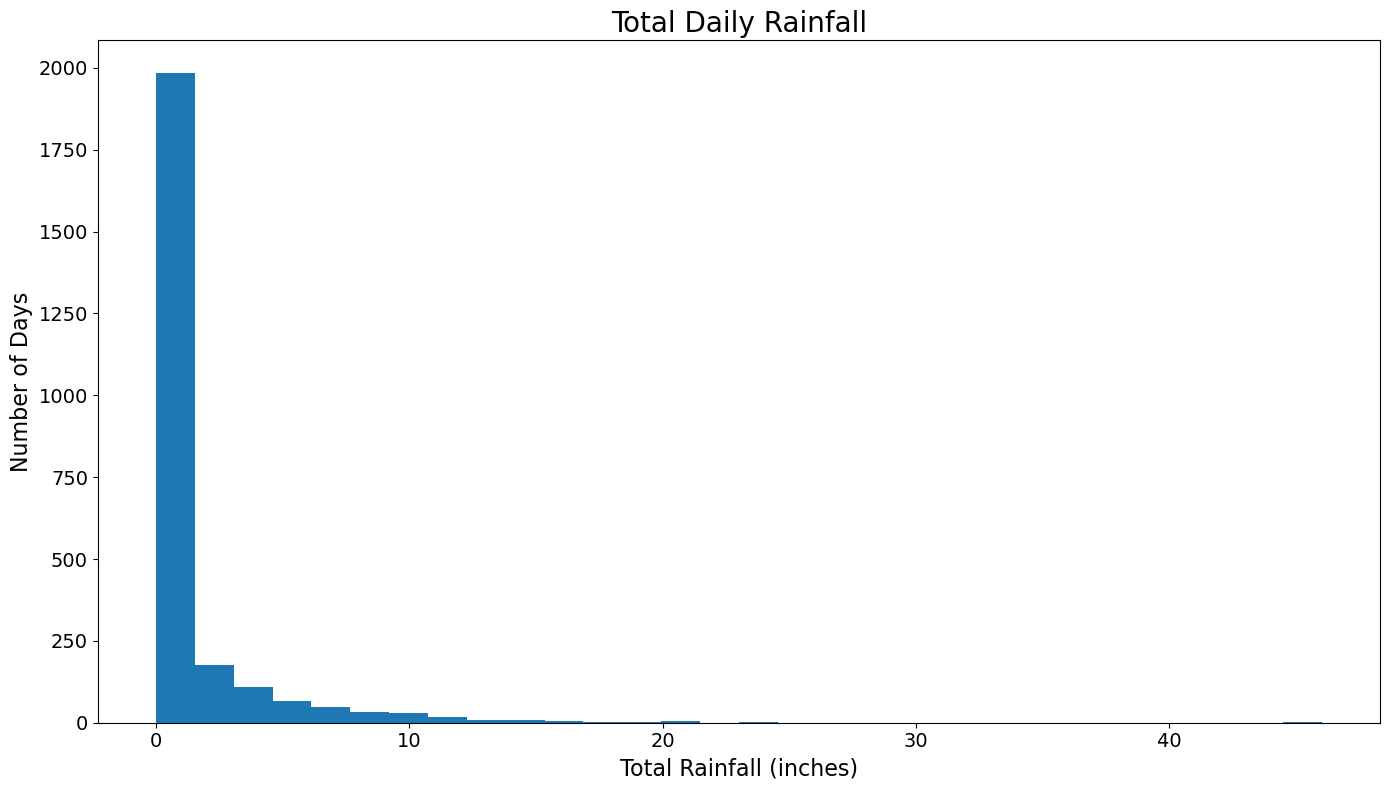

In [7]:
# number of days vs. the total rainfall
plt.figure(figsize=(14,8))

plt.hist(df["total_rain_in"], bins=30)
plt.title("Total Daily Rainfall", fontsize=20)
plt.xlabel("Total Rainfall (inches)", fontsize=16)
plt.ylabel("Number of Days", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


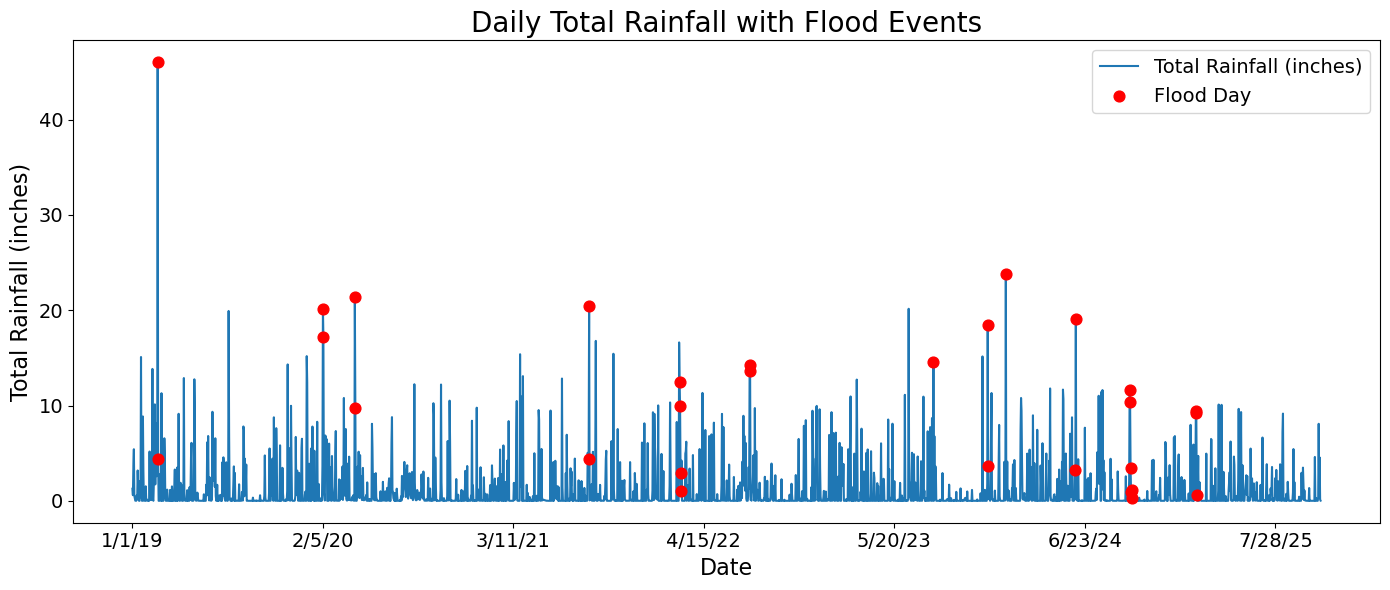

In [8]:
# daily rain with flood days marked
plt.figure(figsize=(14,6))
plt.plot(df["Date"], df["total_rain_in"], label="Total Rainfall (inches)",linewidth=1.5)

flood_days = df[df["Label (Flood/no flood)"] == 1]
plt.scatter(flood_days["Date"], flood_days["total_rain_in"], color="red", s=60,label="Flood Day",zorder=5)

plt.title("Daily Total Rainfall with Flood Events", fontsize=20)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Total Rainfall (inches)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(8))
plt.tight_layout()
plt.show()

This graph shows thats most flood labels are caused by two or more consecutive days of rain.

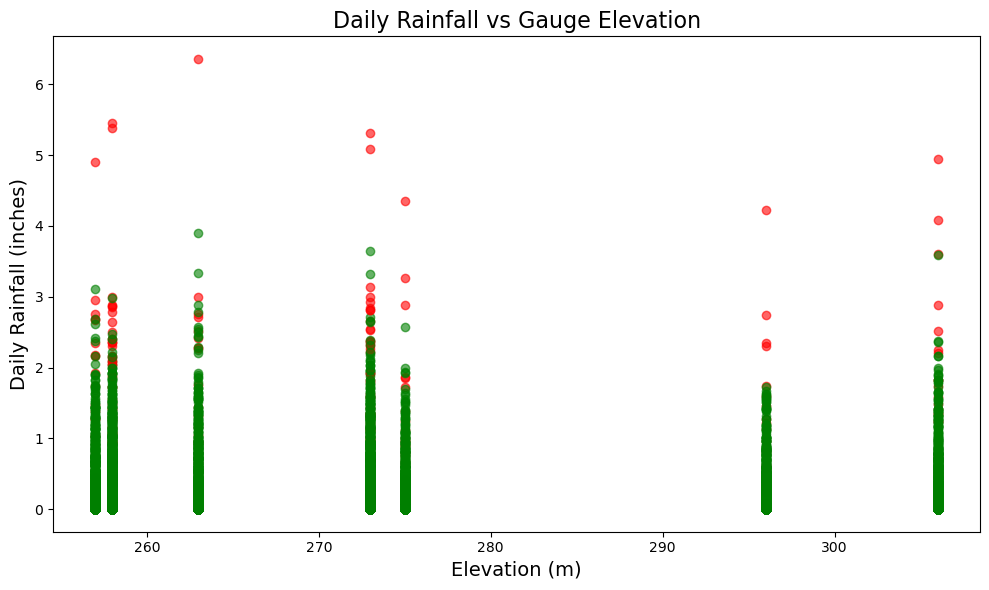

In [9]:
gauge_elevations = {
    "City/Cty Bldg":    275,
    "Fountain City":    306,
    "Adair Drive":      296,
    "KAT Station":      273,
    "Love Creek":       257,
    "Tyson Park":       258,
    "Walden Drive":     263,
    "Williams Creek":   258,
    "NOAA Airport":     273
}

plt.figure(figsize=(10,6))

for gauge, elev in gauge_elevations.items():
    flood_days = df["Label (Flood/no flood)"] == 1
    plt.scatter([elev]*flood_days.sum(), df.loc[flood_days, gauge], 
                color="red", alpha=0.6, label="Flood" if gauge == list(gauge_elevations.keys())[0] else "")
    no_flood_days = df["Label (Flood/no flood)"] == 0
    plt.scatter([elev]*no_flood_days.sum(), df.loc[no_flood_days, gauge], 
                color="green", alpha=0.6, label="No Flood" if gauge == list(gauge_elevations.keys())[0] else "")

plt.xlabel("Elevation (m)", fontsize=14)
plt.ylabel("Daily Rainfall (inches)", fontsize=14)
plt.title("Daily Rainfall vs Gauge Elevation", fontsize=16)
plt.tight_layout()
plt.show()

As expected. More floods at lower elevations

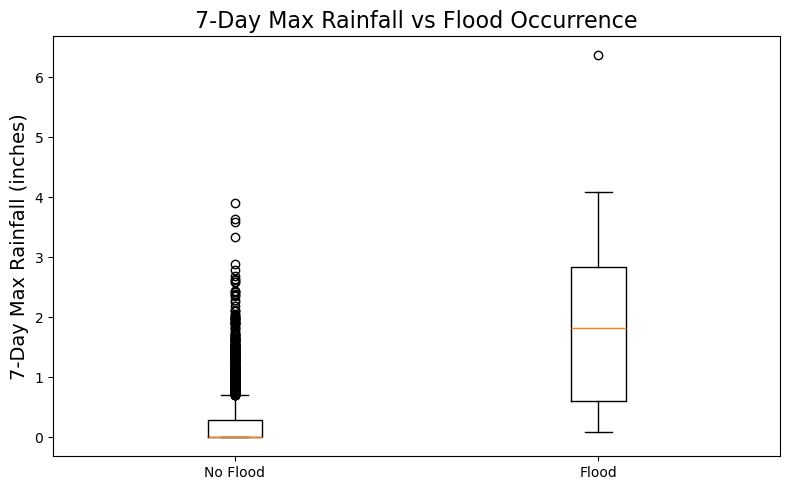

In [10]:
# boxplot of 7 day max by flood occurence
gauges = list(gauge_elevations.keys())
df["rain_7day_max"] = df[gauges].max(axis=1)

flood_days = df[df["Label (Flood/no flood)"] == 1]["rain_7day_max"]
no_flood_days = df[df["Label (Flood/no flood)"] == 0]["rain_7day_max"]

plt.figure(figsize=(8,5))
plt.boxplot([no_flood_days, flood_days], tick_labels=["No Flood", "Flood"])
plt.ylabel("7-Day Max Rainfall (inches)", fontsize=14)
plt.title("7-Day Max Rainfall vs Flood Occurrence", fontsize=16)
plt.tight_layout()
plt.show()

Training accuracy: 0.9935897435897436
Test accuracy: 0.9919871794871795


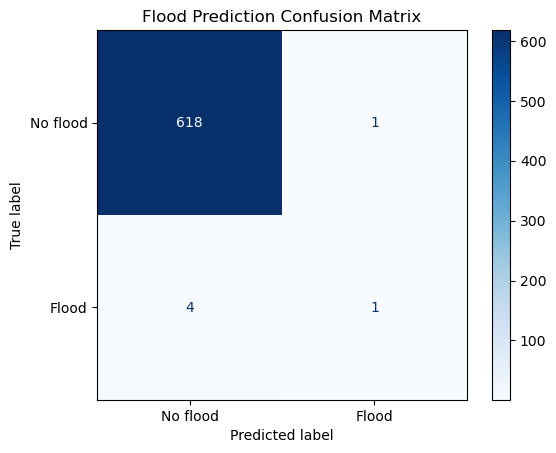


Classification Report:

              precision    recall  f1-score   support

    No Flood       0.99      1.00      1.00       619
       Flood       0.50      0.20      0.29         5

    accuracy                           0.99       624
   macro avg       0.75      0.60      0.64       624
weighted avg       0.99      0.99      0.99       624



In [11]:
#random forest
df["Label (Flood/no flood)"] = pd.to_numeric(df["Label (Flood/no flood)"], errors="coerce").fillna(0).astype(int)
feature_cols = ["total_rain_in","max_daily_rain_in","rain_std","heavy_days",
                "rain_3day_max","rain_7day_max","rolling_14d_total","rolling_30d_total"]

X = df[feature_cols]
y = df["Label (Flood/no flood)"]

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.25, random_state=42)

rf = RandomForestClassifier(n_estimators=200, max_depth=4, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# accuracy
print("Training accuracy:", rf.score(X_train, y_train))
print("Test accuracy:", rf.score(X_test, y_test))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No flood","Flood"])
disp.plot(cmap="Blues")
plt.title("Flood Prediction Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=["No Flood", "Flood"]))



Observations: random forest alone cannot accurately predict on a greatly imbalanced dataset like we ha

Original training set size: (1872, 8)
Resampled training set size: (3696, 8)
Training accuracy: 0.9402056277056277
Test accuracy: 0.9134615384615384


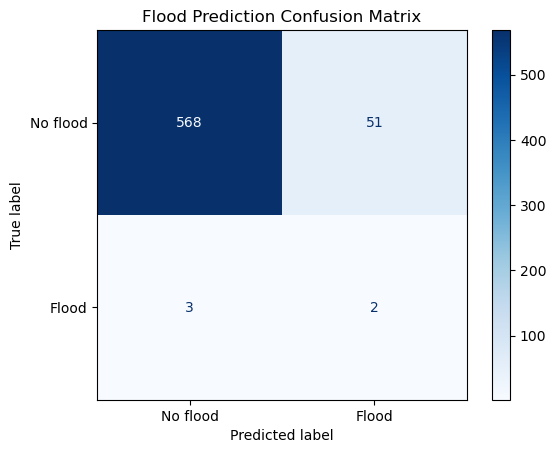


Classification Report:

              precision    recall  f1-score   support

    No Flood       0.99      0.92      0.95       619
       Flood       0.04      0.40      0.07         5

    accuracy                           0.91       624
   macro avg       0.52      0.66      0.51       624
weighted avg       0.99      0.91      0.95       624



In [12]:
# SMOTE and balancing
df["Label (Flood/no flood)"] = pd.to_numeric(df["Label (Flood/no flood)"], errors="coerce").fillna(0).astype(int)
feature_cols = ["total_rain_in","max_daily_rain_in","rain_std","heavy_days",
                "rain_3day_max","rain_7day_max","rolling_14d_total","rolling_30d_total"]

X = df[feature_cols]
y = df["Label (Flood/no flood)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# smote for imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Original training set size:", X_train.shape)
print("Resampled training set size:", X_train_res.shape)

# random forest
rf = RandomForestClassifier(n_estimators=300, max_depth=6, random_state=42, class_weight="balanced")
rf.fit(X_train_res, y_train_res)
y_pred = rf.predict(X_test)

# accuracy
print("Training accuracy:", rf.score(X_train_res, y_train_res))
print("Test accuracy:", rf.score(X_test, y_test))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No flood","Flood"])
disp.plot(cmap="Blues")
plt.title("Flood Prediction Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=["No Flood", "Flood"]))


Observations: Many false alarms, also f1 score (precision is extremely poor) for flood prediction. 

Model Development: 

A Random Forest classifier was first applied, followed by a HistGradientBoostingClassifier, which handles imbalanced data more effectively. Model features included total rainfall, 7-day maximum rainfall, consecutive heavy days, and rainfall per elevation.
To reduce false positives in flood prediction, a higher decision threshold (0.939) was applied to the predicted probabilities. This adjustment ensures that predicted floods are more likely to correspond to actual flood events.

Handling Class Imbalance:

Flood events are rare, resulting in an imbalanced dataset. Initial attempts to oversample the minority class using SMOTE did not substantially improve model performance. Subsequently, ADASYN was applied, which more aggressively oversamples minority cases while considering feature space complexity. This led to a more balanced training dataset and improved model sensitivity to flood events. 

FEATURES AGAIN
Adding elevation into the features

In [13]:
# normalizing by elevation
df["rain_7day_per_elev"] = df["rain_7day_max"] / df["elev_m"]
df["rain_7day_anomaly"] = df["rain_7day_max"] - df["rolling_30d_total"]/30
df["heavy_days_per_elev"] = df["heavy_days"] / df["elev_m"]
df["max_daily_per_elev"] = df["max_daily_rain_in"] / df["elev_m"]
df["heavy_days_7day_ratio"] = df["heavy_days"] / (df["rain_7day_max"] + 1e-8)


Explanation of features: 

rain_7day_per_elev- 
The total rainfall over the last 7 days divided by the elevation at that gauge. Lower elevations are more prone to flooding, so the same 7-day rainfall can have more impact in low areas.

rain_7day_anomaly- 
The 7-day rainfall minus the average daily rainfall over the last 30 days. Measures abnormal rainfall spikes. Flooding is often triggered not just by total rainfall, but by sudden, unusual rainfall compared to the recent baseline. Helps model detect extreme events rather than “typical” rainfall.

heavy_days_per_elev- 
The number of “heavy rainfall” days (rain > 1 inch) normalized by the elevation. Multiple consecutive heavy days saturate the soil, increasing flood risk. Adjusting by elevation helps identify lower areas where repeated heavy rainfall has more impact.

max_daily_per_elev- 
Maximum single-day rainfall divided by elevation. Extreme single-day events can trigger flash floods. Also normalizing by elevation. 

heavy_days_7day_ratio- 
Number of heavy rainfall days divided by total rainfall over the last 7 days. Shows how concentrated the rainfall (2 heavy days vs 7 moderate days). Concentrated heavy rainfall is more likely to cause flooding than evenly spread rain, even if total 7-day rainfall is the same.

Primary driver is total rainfall, but secondary factors include these features to capture short term spikes, like flash floods, and cumulative saturation, longer term flooding. 

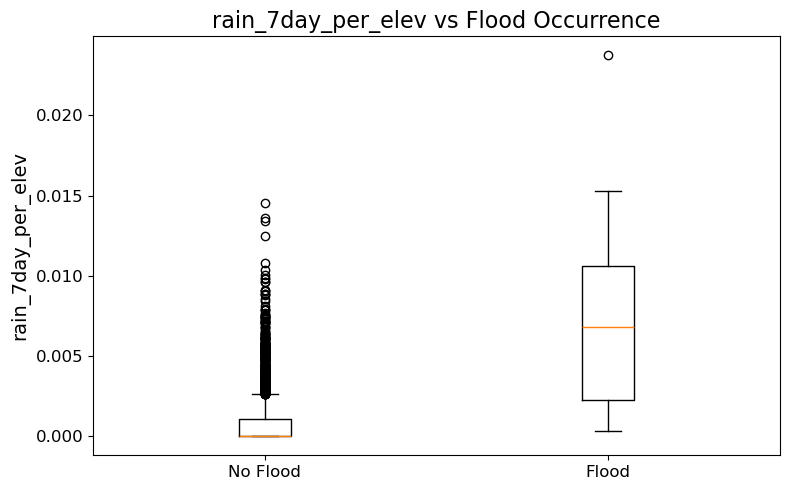

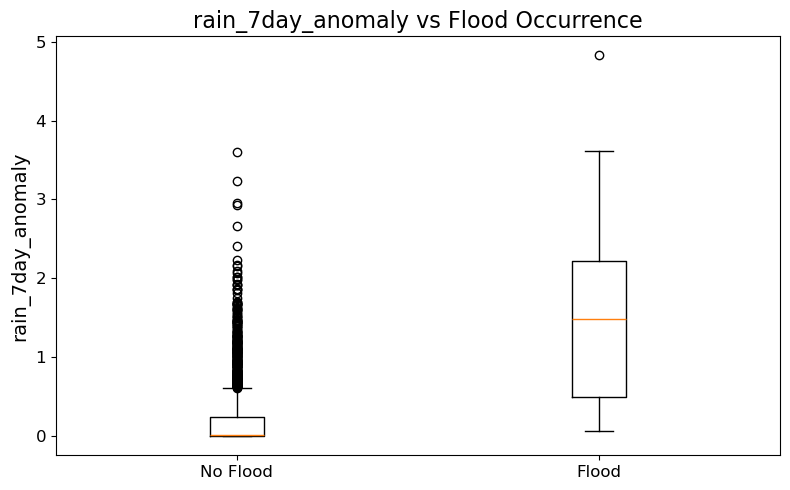

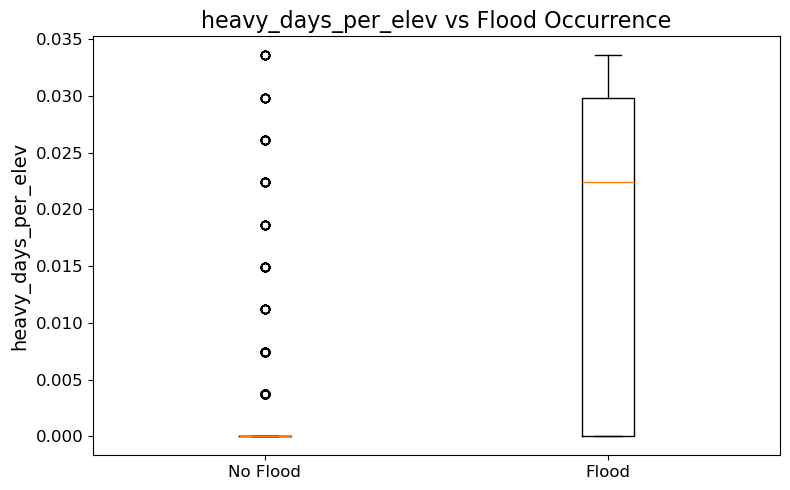

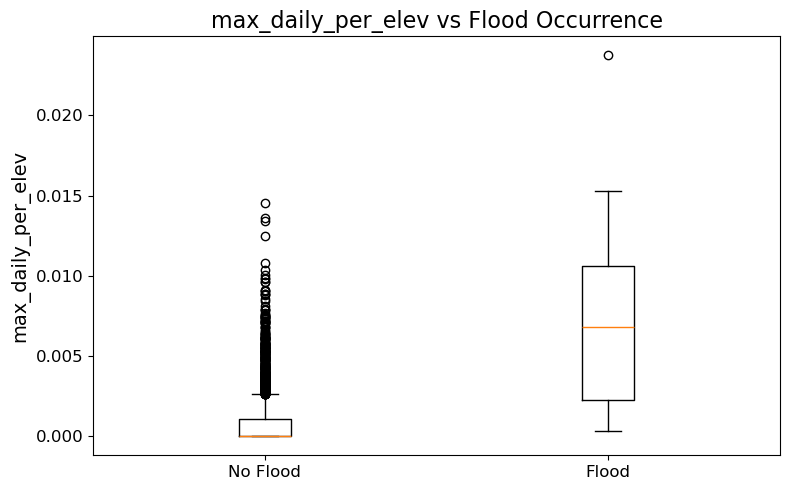

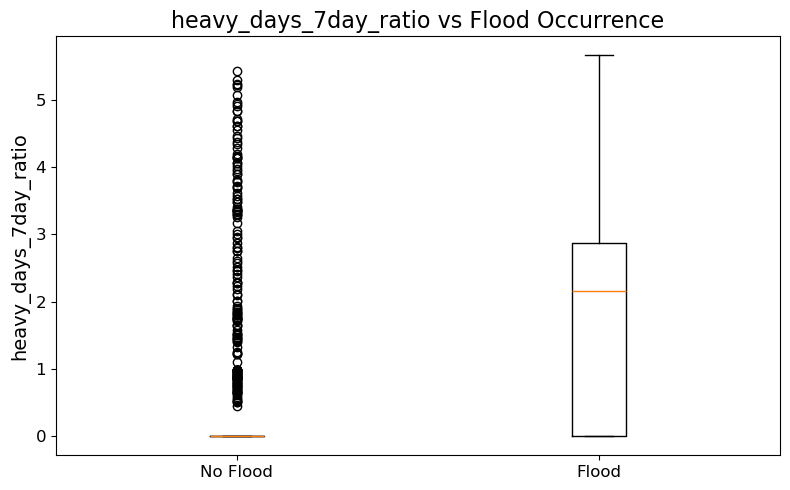

In [18]:
features_to_plot = [
    "rain_7day_per_elev",
    "rain_7day_anomaly",
    "heavy_days_per_elev",
    "max_daily_per_elev",
    "heavy_days_7day_ratio"
]

for feature in features_to_plot:
    plt.figure(figsize=(8,5))

    no_flood = df[df["Label (Flood/no flood)"] == 0][feature]
    flood = df[df["Label (Flood/no flood)"] == 1][feature]
    plt.boxplot([no_flood, flood], tick_labels=["No Flood", "Flood"])
    
    plt.title(f"{feature} vs Flood Occurrence", fontsize=16)
    plt.ylabel(feature, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

Graphs are expected. These features influence flooding and it's expected that they would be seen more on days that flood. 

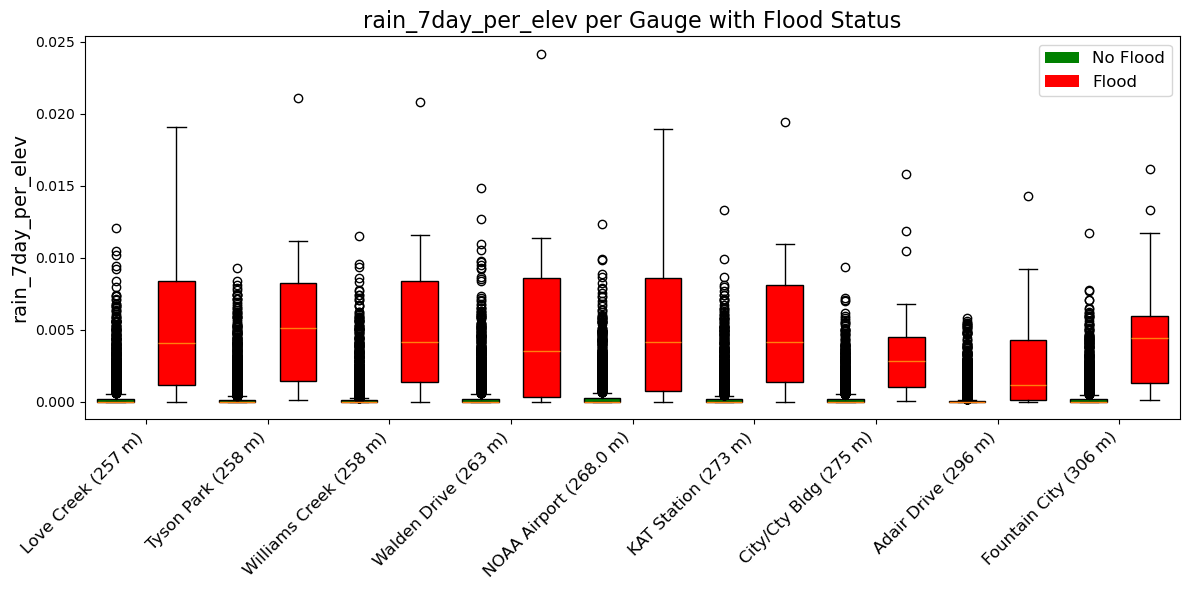

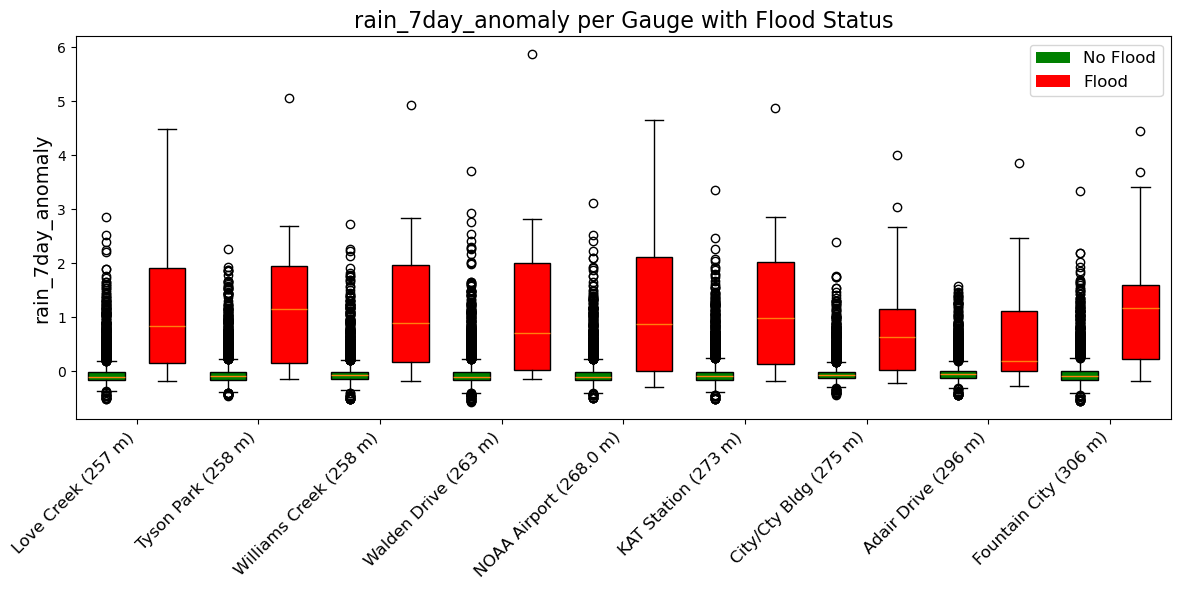

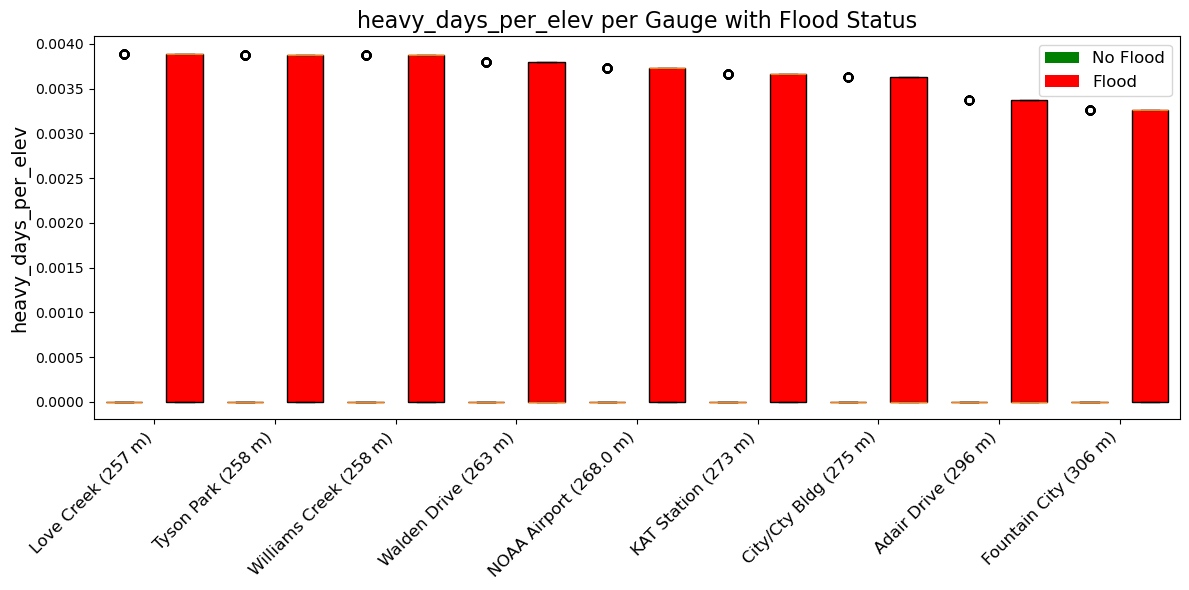

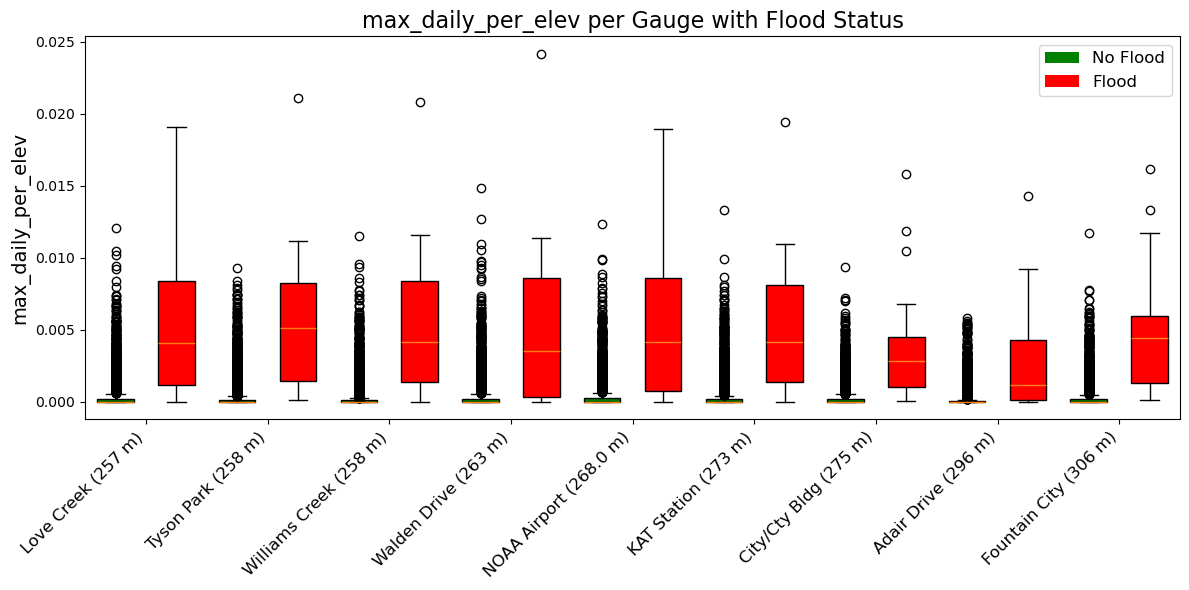

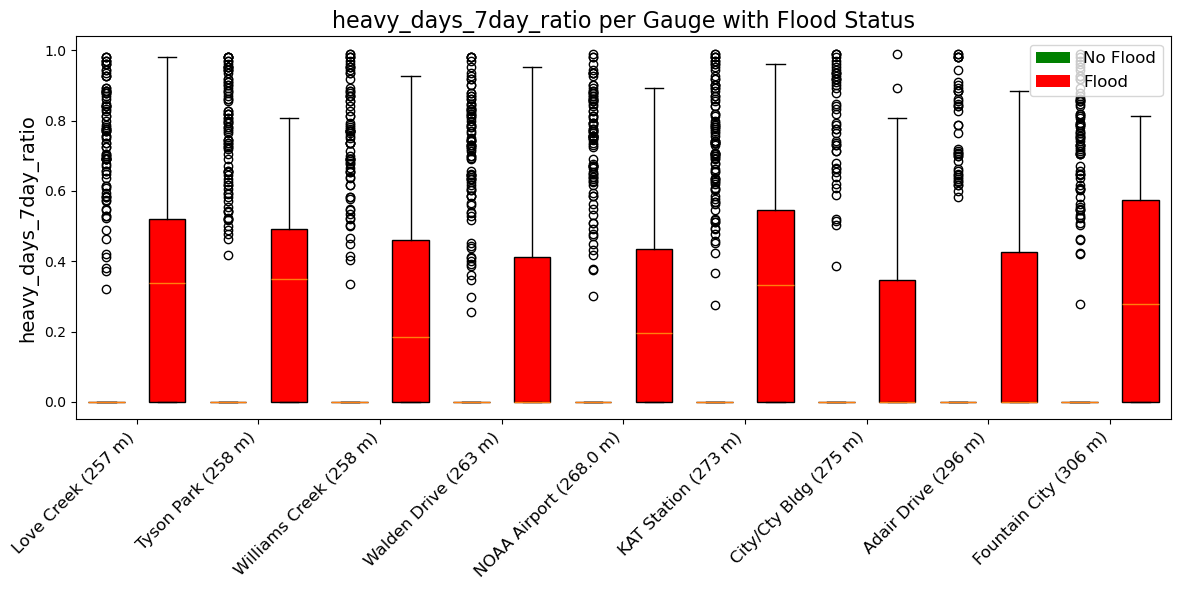

In [19]:
# box plots by gauge
gauge_cols = [c for c in df.columns if c in gauge_info.keys()]

df_long = df.melt(
    id_vars=["Date", "Label (Flood/no flood)"],
    value_vars=gauge_cols,
    var_name="Gauge",
    value_name="Rainfall_in"
)

df_long["elev_m"] = df_long["Gauge"].map(lambda g: gauge_info[g][2])

# recalculate per gauge features
df_long["rain_7day_per_elev"] = df_long["Rainfall_in"] / df_long["elev_m"]
df_long["rain_7day_anomaly"] = df_long["Rainfall_in"] - df_long["Rainfall_in"].rolling(30, min_periods=1).mean()
df_long["heavy_days_per_elev"] = (df_long["Rainfall_in"] > 1).astype(int) / df_long["elev_m"]
df_long["max_daily_per_elev"] = df_long["Rainfall_in"] / df_long["elev_m"]
df_long["heavy_days_7day_ratio"] = (df_long["Rainfall_in"] > 1).astype(int) / (df_long["Rainfall_in"] + 1e-8)

features_to_plot = [
    "rain_7day_per_elev",
    "rain_7day_anomaly",
    "heavy_days_per_elev",
    "max_daily_per_elev",
    "heavy_days_7day_ratio"
]

# sort gauges by elevation
sorted_gauges = sorted(gauge_cols, key=lambda g: gauge_info[g][2])
gauge_labels = [f"{g} ({gauge_info[g][2]} m)" for g in sorted_gauges]

# plotting box plots per gauge
for feature in features_to_plot:
    plt.figure(figsize=(12,6))
    
    box_positions = []
    box_data = []
    colors = []
    
    for i, gauge in enumerate(sorted_gauges):
        gauge_data = df_long[df_long["Gauge"] == gauge]
        
        no_flood = gauge_data[gauge_data["Label (Flood/no flood)"] == 0][feature].values
        flood = gauge_data[gauge_data["Label (Flood/no flood)"] == 1][feature].values
        
        box_positions.extend([i*2, i*2+1])
        box_data.extend([no_flood, flood])
        colors.extend(["green", "red"])
    
    bplots = plt.boxplot(box_data, positions=box_positions, widths=0.6, patch_artist=True)
    
    for patch, color in zip(bplots['boxes'], colors):
        patch.set_facecolor(color)
    
    mid_positions = [i*2 + 0.5 for i in range(len(sorted_gauges))]
    plt.xticks(mid_positions, gauge_labels, fontsize=12, rotation=45, ha='right')
    plt.ylabel(feature, fontsize=14)
    plt.title(f"{feature} per Gauge with Flood Status", fontsize=16)
    
    legend_elements = [Patch(facecolor='green', label='No Flood'),
                       Patch(facecolor='red', label='Flood')]
    plt.legend(handles=legend_elements, fontsize=12)
    plt.tight_layout()
    plt.show()

Mostly larger boxes (more flood statistics) at the lower elevations. 

Training accuracy: 0.9981055480378891
Test accuracy: 0.9759615384615384


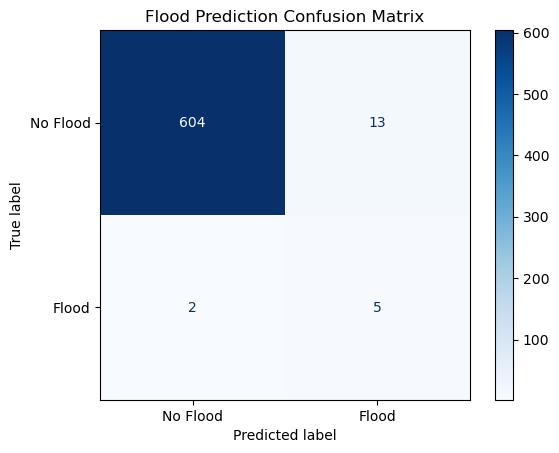


Classification Report:

              precision    recall  f1-score   support

    No Flood       1.00      0.98      0.99       617
       Flood       0.28      0.71      0.40         7

    accuracy                           0.98       624
   macro avg       0.64      0.85      0.69       624
weighted avg       0.99      0.98      0.98       624



In [27]:
# ADYSN- agressive oversampling

df["Label (Flood/no flood)"] = pd.to_numeric(df["Label (Flood/no flood)"], errors="coerce").fillna(0).astype(int)

feature_cols = [
    "total_rain_in","max_daily_rain_in","rain_std","heavy_days",
    "rain_3day_max","rain_7day_max","rolling_14d_total","rolling_30d_total",
    "consecutive_heavy_days","rain_7day_per_elev","rain_7day_anomaly"
]

X = df[feature_cols]
y = df["Label (Flood/no flood)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

adasyn = ADASYN(sampling_strategy=1, random_state=42)
X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)

clf = HistGradientBoostingClassifier(
    max_iter=300,
    max_depth=6,
    random_state=42,
    class_weight="balanced"
)

clf.fit(X_train_res, y_train_res)

y_prob = clf.predict_proba(X_test)[:, 1]

# apply custom threshold
threshold = 0.9
y_pred_threshold = (y_prob >= threshold).astype(int)

print("Training accuracy:", clf.score(X_train_res, y_train_res))
print("Test accuracy:", (y_pred_threshold == y_test).mean())

cm = confusion_matrix(y_test, y_pred_threshold)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Flood","Flood"])
disp.plot(cmap="Blues")
plt.title("Flood Prediction Confusion Matrix")
plt.show()

# classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_threshold, target_names=["No Flood", "Flood"]))


In [26]:
thresholds = np.linspace(0.1, 0.9, 50)
f1_scores = []
for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print("Best threshold:", best_threshold)
print("Max F1 score:", f1_scores[best_idx])

Best threshold: 0.8836734693877552
Max F1 score: 0.4


Model Evaluation: 

Model performance was assessed using accuracy, confusion matrices, precision, recall, and F1-score. Visualizations of confusion matrices show that the model is able to correctly identify most flood events while minimizing false positives.
Although the model performs well on the current dataset, it has not yet been validated on a completely unknown dataset.

Insights: 

The most significant predictors of flooding are:
- 7-day maximum rainfall
- Consecutive heavy rainfall days
- Rainfall adjusted for elevation

These results align with exploratory data analysis, that is, areas with sustained heavy rainfall and lower elevations are more prone to flooding.

Analysis of feature importance indicates that the most significant predictors of flooding are:
7-day maximum rainfall
Consecutive heavy rainfall days
Rainfall adjusted for elevation
These results align with exploratory data analysis: areas with sustained heavy rainfall and lower elevations are more prone to flooding.

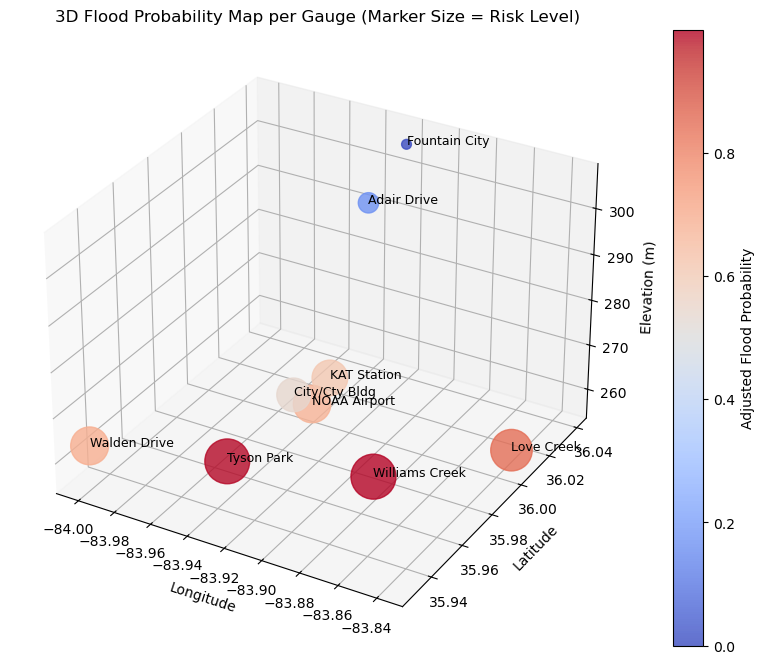

In [22]:
gauge_cols = [c for c in df.columns if c in gauge_info.keys()]

# rainfall 
per_gauge_probs = {}
for gauge in gauge_cols:
    per_gauge_probs[gauge] = df.loc[df["Label (Flood/no flood)"]==1, gauge].mean() / df[gauge].mean()

# adjust for elevation
elevs = np.array([gauge_info[g][2] for g in gauge_cols])
max_elev = elevs.max()
min_elev = elevs.min()

adjusted_probs = {}
for i, gauge in enumerate(gauge_cols):
    adjusted_probs[gauge] = per_gauge_probs[gauge] * ((max_elev - elevs[i]) / (max_elev - min_elev + 1e-8))

# normalize
max_prob = max(adjusted_probs.values())
min_prob = min(adjusted_probs.values())
plot_probs = {g: (adjusted_probs[g] - min_prob)/(max_prob - min_prob + 1e-8) for g in gauge_cols}

# create df
plot_df = pd.DataFrame({
    "gauge": gauge_cols,
    "lat": [gauge_info[g][0] for g in gauge_cols],
    "long": [gauge_info[g][1] for g in gauge_cols],
    "elev_m": [gauge_info[g][2] for g in gauge_cols],
    "pred_prob": [plot_probs[g] for g in gauge_cols]
})

# 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

sizes = plot_df["pred_prob"] * 1000 + 50
sc = ax.scatter(plot_df["long"], plot_df["lat"], plot_df["elev_m"], s=sizes,
                c=plot_df["pred_prob"], cmap='coolwarm', alpha=0.8)

for _, row in plot_df.iterrows():
    ax.text(row["long"], row["lat"], row["elev_m"], row["gauge"], fontsize=9)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Elevation (m)")
plt.title("3D Flood Probability Map per Gauge (Marker Size = Risk Level)")
fig.colorbar(sc, label="Adjusted Flood Probability")
plt.show()

Still need to use our model on a dataset it hasnt seen. 